# Legal Citation Classification
Ka Yu Lau (Gary) last update 25 Jun 2019

## Introduction

Information overload is a problem in the legal field. Legal professional has spent hours in reading documents. Effort has been made to summarise legal documents in the past two decades. However, due to longer average length, the style of writing and the convoluted and philosophical nature of legalese, legal documents were seen to be more difficult to classify compare to scientific article and news (**Hachey and Grover** )

In 2010, UNSW researchers, Galgani and Hoffmann, create a system called 'LEXA'(Legal tEXt Analyzer). The system aimed to reduce legal professionals' information overload by summarizing information in case reports. One of the appoarches LEXA used to acquire knowledge from the documents is through citation classification. 

Based on *Stare Decisis* in common law, judgement is based on previous cases and decisions on how the law was interpreted. Past decisions has a binding effect on following decisons. Court decisions or cases can be instructive as they introduce a new principle or rule, modify or interpret an existing principle or rule, or settle a question upon which the law is doubtful. Galgani and Hoffmann suggested: by classiying legal citations in the case document, we extract a important information about a legal document which helps the summarisation of legal document.

This paper aim to extend the prior work by Galigani and Hoffmann with LEXA,  which used Rule-based method, to other machine learning based method and convolutional neural network.

## Related Work

**Legal Citation Classification**

As mentioned in Galgani and Hoffmann's paper, LEXA's classification rules are created under the monitor of a domain expert and based on regular experssion in the text. Expert made corrections to the rule when error occurs in building their knowledge base. This incremental refinements method is called Ripple-Down Rule (RDR) (Compton and Jansen,1990).  Although domain expert have not involved in our project, we adopted their approach in measuring the performance of the model such as precision, recall and F1-measure and used their result as a benchmark of our models.

## Goal of this Project

The goal of this project is classifying whether the legal citation is accepted or rejected by the court. The definition of citation is as followed:

- **Allow** - A principle of law articulated in the primary case is applied to a new set of facts by the court in the subsequent case.
- **Follow** - The annotation is similar to applied but is used in circumstances where the facts in the primary case resemble reasonably closely the facts in the subsequent consideration case
- **Distinguished** - The court in the subsequent case holds that the legal principles articulated by the primary case (usually otherwise persuasive or binding authority) do not apply because of some difference between the two cases in fact or law

To simplify our classification problem and to be compared to Galgaini's previous work, we have combined the groups into "**Follow/Allow**"(FA) or "**Distinguished**"(D).

## Data

**Sample of the dataset**

This [dataset] contains Australian legal cases from the Federal Court of Australia (FCA). The data included 3890 cases from the year 2006,2007,2008 and 2009. Citation classes are indicated in the document, and indicate the type of treatment given to the cases cited by the present case. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')
train.head()

,label,text
0,followed,13 It was not suggested in this proceeding tha...
1,followed,"15 Strictly speaking, a cheque, even a bank ch..."
2,followed,16 None of this is to suggest that the Deputy ...
3,followed,16 None of this is to suggest that the Deputy ...
4,followed,22 The true position is that the applicant's s...


In [3]:
test.head()

,label,text
0,applied,The recent decision of the High Court in Austr...
1,followed,In Hexal Australia Pty Ltd v Roche Therapeutic...
2,followed,None
3,followed,"The material facts in Purchas, in the matter o..."
4,followed,"The material facts in Purchas, in the matter o..."


# Data Investigation

In [4]:
print(train.isnull().sum())
train = train.dropna()
print(test.isnull().sum())
test = test.dropna()

label     0
text     10
dtype: int64
label    0
text     9
dtype: int64


There 10 missing text in the train set and 9 missing text in test set. This are observation are record are ignored as we cannot extract any features from it.

In [ ]:
doc.sentence()

## Data Preprocessing

In [6]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
def relabel(df):
    '''
    relabel follow/applied in to one group and distinguished the other
    return: the new dataframe
    '''
    print('before transform:', df.label.unique())
    df.label = df.label.replace('followed',1)
    df.label = df.label.replace('applied',1)
    df.label = df.label.replace('distinguished',0)
    print('after transform:', df.label.unique())
    df.label.value_counts()
    return df
train = relabel(train)
test = relabel(test)

before transform: ['followed' 'applied' 'distinguished']
after transform: [1 0]
before transform: ['applied' 'followed' 'distinguished']
after transform: [1 0]


In [8]:
print('Case Citation Label:', train['label'].iloc[0])
print('Description in Case Report:', train['text'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Case Citation Label: 1
Description in Case Report: 13 It was not suggested in this proceeding that, so far as a Commonwealth revenue debt is concerned, there is any express statutory provision which alters the usual position which prevails as between creditor and debtor when a cheque is given in payment of a debt. That usual position was expressed by Mason CJ, Brennan, Deane, Dawson and Toohey JJ in National Australia Bank v KDS Construction Services Pty Ltd [1987] HCA 65 ; (1987) 163 CLR 668 , at 676 to be as follows:
 Generally speaking, when a cheque is given in payment of a debt, it operates as a conditional payment. The payment is subject to a condition that the cheque be paid on presentation. If it is dishonoured the debt revives. Although it is sometimes said that the remedy for the primary debt is suspended, the suspension is no more than a consequence of the conditional nature of the payment: Tilley v Official Receiver in Bankruptcy [1960] HCA 86 ; (1960) 103 CLR 529 , at pp 5

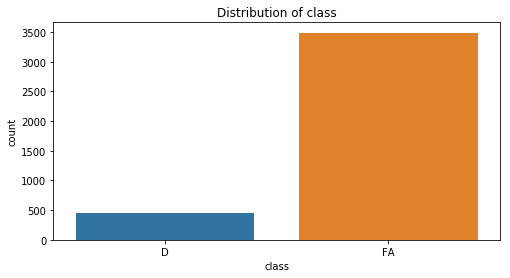

In [15]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train['label'].value_counts().index, y=train['label'].value_counts())
plt.ylabel('count');plt.xlabel('class')
plt.xticks([0,1],('D','FA'))
plt.title('Distribution of class')
plt.show()

As seen from the barplot, the data is severely inbalance. As this will cause prediction problem to us.
We will ovrersample it in the later part

# Conventional Machine Learning

## Data Preparation

### Feature Extraction
For feature extraction in conventional machine learning, we used the stop words list from spacy to remove the common words in the text. Then the text will be breakdown into tokens. As we would like to experiment the effect of different features, we first calculate tf-idf, count and occurence for bag of words. Then we expand that to 2-gram, 3-gram and mix of unigram, 2gram and 3 gram. 

Due to the length of the text, it is possible to have a word matrix with features more than the observation. To avoid the curse of dimensionality, we limited our word vector to only having 1000 features.

In [18]:
from model_utility import feature_extraction
n_features = 1000
# unigram
count,occur,tfidf = feature_extraction(stopwords, (1,1), n_features)
# 2gram
count_2,occur_2,tfidf_2 = feature_extraction(stopwords, (2,2), n_features)
# 3gram
count_3,occur_3,tfidf_3 = feature_extraction(stopwords, (3,3), n_features)
# mixed 1,2,3 grams
count_123,occur_123,tfidf_123 = feature_extraction(stopwords, (1,3), n_features)

### Resampling
As discussed earlier, the data set is severely imbalance. In order to increase the weight of the minority class, we applied naive random-oversample to oversample the minority class. Based on our grid search result, we oversampled the minority 30% of the majority class. 

In [11]:
# resampleling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.3)

### Modeling
**Multinomial Naive Bayes**

As mentioned, multinomial naive bayes is used by Galgani. Assuming different class citation summary uses different vocabulary,  multinomial naive bayes applied bayes theorem to classify the document. It takes the probability of token occured in the document(prior distribution) to estimate the probability of which class the citation belongs to (posterior distirbution).

**Decsion Tree**

LEXA used decision rule based on regular expression to spit the data into two classes. Decsion tree used a similar approach by spitting nodes based on the statistic of  a feature. As some words can appears a lot while some do not, the frequency of token can be very different. Since decision tree is insensitive to extreme values,  it is suitable for this senario.

**Logisitic Regression**

Treating each word as a predictor in a logistic regression model, logistic regression estimate how much the occurence of certain word increases the chance of the document being one of the group.

**Support Vector Machine**

Consider each of the word as a dimention, support vector machine tries find a multi-dimensional plane that can seperate the two classes. This assumption certain word can identify class is similar to picking up the conditions in the text that LEXA used.

**K-nearest Neighbours**

We assumed if two documents used similar words are more likely to belong to the same class. K-nearest Neighbour classified classify based on  which class of the closest K observations of the new observaton belongs to. 

**Essemble Method: voting**

We founded the models we create from the basic technique tends to overfit and produce low prediction for the minority. We tried essemble methods  that combine the results of weaker models to provide a stronger model. The technique we used is called voting. Each of the model provides a result (vote) which class the citation belongs to. The class get the most vote wins. 

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree,linear_model
from sklearn.ensemble import VotingClassifier
mnb = MultinomialNB(alpha=0.7)
dtc = tree.DecisionTreeClassifier(max_depth=12)
lm = linear_model.LogisticRegression(solver='lbfgs')
knn = KNeighborsClassifier(n_neighbors=27)
svm  = SVC(gamma='auto')
eclf = VotingClassifier(estimators=[('dt', dtc), ('knn', knn), ('svc', svm),('log',lm),('mnb',mnb)], voting='hard')

### Baseline Model

In [39]:
from model_utility import nlp_pipeline, model_score
predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, occur, mnb,ros)
baseline_score = model_score(test.label.ravel(),predicted)
baseline_score

{'1_precision_D': 0.2605633802816901,
 '2_recall_D': 0.4625,
 '3_F1_D': 0.33333333333333337,
 '4_precision_FA': 0.9247594050743657,
 '5_recall_FA': 0.8342541436464088,
 '6_F1_FA': 0.8771784232365145,
 '7_accuracy': 0.7925718290119131}

We will also use Galgani's result as our benchmark.

In [40]:
# result from Galgani's paper in 2010
LEXA_train = {'1_precision_D': 0.784,'2_recall_D': 0.417,'3_F1_D': 0.545,
              '4_precision_FA': 0.928, '5_recall_FA': 0.985, '6_F1_FA': 0.955,'7_accuracy': 0.919}
LEXA_test = {'1_precision_D': 0.5,'2_recall_D': 0.263,'3_F1_D': 0.344,
              '4_precision_FA': 0.913, '5_recall_FA': 0.967, '6_F1_FA': 0.939,'7_accuracy': 0.888}
Galgani_NB4s_train = {'1_precision_D': 0.824,'2_recall_D': 0.772,'3_F1_D': 0.797,
              '4_precision_FA': 0.971, '5_recall_FA': 0.979, '6_F1_FA': 0.975,'7_accuracy': 0.955}
Galgani_NB4s_test = {'1_precision_D': 0.493,'2_recall_D': 0.206,'3_F1_D': 0.291,
              '4_precision_FA': 0.907, '5_recall_FA': 0.973, '6_F1_FA': 0.939,'7_accuracy': 0.888}
G_train = [LEXA_train,Galgani_NB4s_train]
G_test = [LEXA_test,Galgani_NB4s_test]

## Test of different classifiers

In [41]:
classifier = [dtc,mnb,knn,lm,svm,eclf]
result = []
for c in classifier:
    predicted = nlp_pipeline(train.text, train.label.ravel(), train.text, occur,c,ros)
    score = model_score(train.label,predicted)
    result.append(score)
classifier_train = pd.DataFrame(result+G_train, index=['dtc','mnb','knn','log','svm','voter','LEXA','G_NB4s'])
classifier_train.transpose()

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


,dtc,mnb,knn,log,svm,voter,LEXA,G_NB4s
1_precision_D,0.842553,0.438735,0.541045,0.929515,0.962963,0.969419,0.784,0.824
2_recall_D,0.860870,0.723913,0.315217,0.917391,0.113043,0.689130,0.417,0.772
3_F1_D,0.851613,0.546349,0.398352,0.923414,0.202335,0.805591,0.545,0.797
4_precision_FA,0.981609,0.960201,0.914449,0.989130,0.895277,0.960530,0.928,0.971
5_recall_FA,0.978797,0.877937,0.964756,0.990831,0.999427,0.997135,0.985,0.979
6_F1_FA,0.980201,0.917228,0.938929,0.989980,0.944490,0.978490,0.955,0.975
7_accuracy,0.965063,0.860000,0.889114,0.982278,0.896203,0.961266,0.919,0.955


In [42]:
result = []
for c in classifier:
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, occur,c,ros)
    score = model_score(test.label,predicted)
    result.append(score)
classifier_test = pd.DataFrame(result+G_test, index=['dtc','mnb','knn','log','svm','voter','LEXA','G_NB4s'])
classifier_test.transpose()

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


,dtc,mnb,knn,log,svm,voter,LEXA,G_NB4s
1_precision_D,0.216346,0.260563,0.303030,0.299465,0.750000,0.569231,0.500,0.493
2_recall_D,0.281250,0.462500,0.187500,0.350000,0.018750,0.231250,0.263,0.206
3_F1_D,0.244565,0.333333,0.231660,0.322767,0.036585,0.328889,0.344,0.291
4_precision_FA,0.905660,0.924759,0.902108,0.916129,0.889670,0.909692,0.913,0.907
5_recall_FA,0.871350,0.834254,0.945541,0.896606,0.999211,0.977901,0.967,0.973
6_F1_FA,0.888174,0.877178,0.923314,0.906262,0.941264,0.942564,0.939,0.939
7_accuracy,0.805186,0.792572,0.860547,0.835319,0.889278,0.894184,0.888,0.888


Using occurrence as our features, we saw the training and testing performance of the models trained by different algorithm compare to LEXA and G_NB4s(Naïve Bayes Classifier based on sentences by Galgani). All the models showed high accuracy as expected. MNB and KNN’s F1_measure(D)(F1_D) is low shows that their performance on classifying the minority class was poor. SVM classified the minority class with a high precision but it didn’t capture only a few of the class D citation (low recall). Decision tree and logistic regression shows a good result in training set but they all overfitted the training data and performance dropped significantly in test data. 
However, by combining all these weaker models with voting, we build a model which performed as well as LEXA. The precision of our ensemble model is better than LEXA but it did not capture as much minority class as LEXA did.

### Test of different number of words in a token

In [46]:
gram = [occur,occur_2,occur_3,occur_123]
result = []
for f in gram:
    predicted = nlp_pipeline(train.text, train.label.ravel(), train.text, f,mnb,ros)
    score = model_score(train.label,predicted)
    result.append(score)
gram_train = pd.DataFrame(result,index=['unigram','2gram','3gram','mixed'])
gram_train.transpose()

,unigram,2gram,3gram,mixed
1_precision_D,0.438735,0.411844,0.305315,0.371298
2_recall_D,0.723913,0.665217,0.536957,0.708696
3_F1_D,0.546349,0.508728,0.389283,0.487294
4_precision_FA,0.960201,0.951980,0.932187,0.956380
5_recall_FA,0.877937,0.874785,0.838968,0.841834
6_F1_FA,0.917228,0.911752,0.883125,0.895459
7_accuracy,0.860000,0.850380,0.803797,0.826329


In [51]:
gram = [occur,occur_2,occur_3,occur_123]
result = []
for f in gram:
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, f,mnb,ros)
    score = model_score(test.label,predicted)
    result.append(score)
gram_test =pd.DataFrame(result,index=['unigram','2gram','3gram','mixed'])
gram_test.transpose()

,unigram,2gram,3gram,mixed
1_precision_D,0.260563,0.204152,0.168224,0.223214
2_recall_D,0.462500,0.368750,0.337500,0.468750
3_F1_D,0.333333,0.262806,0.224532,0.302419
4_precision_FA,0.924759,0.911248,0.904159,0.922090
5_recall_FA,0.834254,0.818469,0.789266,0.794002
6_F1_FA,0.877178,0.862370,0.842815,0.853265
7_accuracy,0.792572,0.768045,0.738612,0.757533


For number of grams, unigram worked the best and as number of word per token increased, the model has a poorer performance. However, a potential reason for the result can be result from us removing the stop word in data preprocessing which destructed the meaning of multiple words.

### Test of different features

In [52]:
feature = [occur,count,tfidf]
result = []
for f in feature:
    predicted = nlp_pipeline(train.text, train.label.ravel(), train.text, f,mnb,ros)
    score = model_score(train.label,predicted)
    result.append(score)
feature_train = pd.DataFrame(result,index=['occur','count','tfidf'])
feature_train.transpose()

,occur,count,tfidf
1_precision_D,0.438735,0.369032,0.884615
2_recall_D,0.723913,0.621739,0.050000
3_F1_D,0.546349,0.463158,0.094650
4_precision_FA,0.960201,0.945197,0.888634
5_recall_FA,0.877937,0.859885,0.999140
6_F1_FA,0.917228,0.900525,0.940653
7_accuracy,0.860000,0.832152,0.888608


In [53]:
feature = [occur,count,tfidf]
result = []
for f in feature:
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, f,mnb,ros)
    score = model_score(test.label,predicted)
    result.append(score)
feature_test = pd.DataFrame(result,index=['occur','count','tfidf'])
feature_test.transpose()

/Users/garylau/Documents/Macquarie University/LocalStudy/ITEC873/legal_citation_classification/model_utility.py:61: RuntimeWarning: invalid value encountered in double_scalars
  F1_D = 2*(precision_D*recall_D)/(precision_D+recall_D)


,occur,count,tfidf
1_precision_D,0.260563,0.232082,0.000000
2_recall_D,0.462500,0.425000,0.000000
3_F1_D,0.333333,0.300221,NaN
4_precision_FA,0.924759,0.918871,0.887798
5_recall_FA,0.834254,0.822415,0.999211
6_F1_FA,0.877178,0.867972,0.940215
7_accuracy,0.792572,0.777856,0.887176


Using MNB as our algorithm, we set up a test on different type of features. Although tfidf performed the best in the training stage, it showed a low recall(D) which means the model cannot capture the minority class despite having a high precision. As result, occurrence of a particular word is a better feature to use. This also shows that the occurrence of a particular word is more important than how many times the word appeared.

## Discussion
To deal with the imbalance of the data set, we adopted  naïve random oversampling to solve this issues. However, oversampling did not provide more information about the minority class. This leads to all the models failed to capture class D citations. In future study, we can explore under-sampling technique to combine majority class observations so the features that both class shared can be less overlap. 


As applying ensemble technique shows some performance improvement, future study can be focus on adjusting the weight of the weaker models and even exploring other ensemble method such as boosting. 


# Appendix
All the Grid Search result for tuning the parameter of the model will be store in this section

In [196]:
# Ratio for oversampling
ratio = [i/10 for i in range(2,11)]
result = []
for r in ratio:
    ros = RandomOverSampler(random_state=0, sampling_strategy = r)
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, occur,mnb,ros)
    score = model_score(test.label,predicted)
    result.append(score)
pd.DataFrame(result,index=ratio).transpose()

,F1_D,F1_FA,accuracy,precision_D,precision_FA,recall_D,recall_FA
0.2,0.342105,0.898949,0.824807,0.295455,0.921292,0.40625,0.877664
0.3,0.359375,0.900405,0.827610,0.308036,0.924356,0.43125,0.877664
0.4,0.327189,0.879339,0.795375,0.259124,0.922810,0.44375,0.839779
0.5,0.317073,0.857748,0.764541,0.234940,0.925114,0.48750,0.799526
0.6,0.317460,0.853617,0.758935,0.232558,0.926131,0.50000,0.791634
0.7,0.313576,0.845989,0.748423,0.225895,0.926692,0.51250,0.778216
0.8,0.322222,0.841832,0.743518,0.228947,0.930277,0.54375,0.768745
0.9,0.322581,0.835366,0.735109,0.226131,0.931973,0.56250,0.756906
1.0,0.316163,0.831951,0.730203,0.220844,0.930664,0.55625,0.752170


In [252]:
#check alpha for multinormial naive bayes
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.3)
alpha = [i/10 for i in range(1,10)]
result = []
for r in alpha:
#     ros = RandomOverSampler(random_state=0, sampling_strategy = r)
    mnb = MultinomialNB(alpha=r)
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, occur,mnb,ros)
    score = model_score(test.label,predicted)
    result.append(score)
CV = pd.DataFrame(result,index=alpha)
CV.transpose()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
F1_D,0.330317,0.329571,0.329571,0.329571,0.329571,0.329571,0.333333,0.333333,0.333333
F1_FA,0.877280,0.876815,0.876815,0.876815,0.876815,0.876815,0.877178,0.877178,0.877178
accuracy,0.792572,0.791871,0.791871,0.791871,0.791871,0.791871,0.792572,0.792572,0.792572
precision_D,0.258865,0.257951,0.257951,0.257951,0.257951,0.257951,0.260563,0.260563,0.260563
precision_FA,0.924017,0.923951,0.923951,0.923951,0.923951,0.923951,0.924759,0.924759,0.924759
recall_D,0.456250,0.456250,0.456250,0.456250,0.456250,0.456250,0.462500,0.462500,0.462500
recall_FA,0.835043,0.834254,0.834254,0.834254,0.834254,0.834254,0.834254,0.834254,0.834254


In [219]:
#check decision tree best depth
depth = [i for i in range(10,20,1)]
result = []
for d in depth:
#     ros = RandomOverSampler(random_state=0, sampling_strategy = r)
    dtc = tree.DecisionTreeClassifier(max_depth=d)
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, occur,dtc,ros)
    score = model_score(test.label,predicted)
    result.append(score)
CV = pd.DataFrame(result,index=depth)
CV.transpose()

,10,11,12,13,14,15,16,17,18,19
F1_D,0.250681,0.264550,0.263158,0.245014,0.257534,0.219718,0.225352,0.205714,0.206186,0.247253
F1_FA,0.889425,0.887722,0.899682,0.894127,0.891121,0.889156,0.889956,0.888978,0.875101,0.889960
accuracy,0.807288,0.805186,0.823406,0.814296,0.810091,0.805886,0.807288,0.805186,0.784163,0.807989
precision_D,0.222222,0.229358,0.247253,0.225131,0.229268,0.200000,0.205128,0.189474,0.175439,0.220588
precision_FA,0.906557,0.909016,0.907631,0.905340,0.907529,0.901786,0.902597,0.899757,0.899917,0.905969
recall_D,0.287500,0.312500,0.281250,0.268750,0.293750,0.243750,0.250000,0.225000,0.250000,0.281250
recall_FA,0.872928,0.867403,0.891871,0.883189,0.875296,0.876875,0.877664,0.878453,0.851618,0.874507


In [258]:
#check number of neighbor for knn
neigh = [i for i in range(20,31,1)]
result = []
for k in neigh:
#     ros = RandomOverSampler(random_state=0, sampling_strategy = r)
    knn = KNeighborsClassifier(n_neighbors=k)
    predicted = nlp_pipeline(train.text, train.label.ravel(), test.text, occur,knn,ros)
    score = model_score(test.label,predicted)
    result.append(score)
CV = pd.DataFrame(result,index=neigh)
CV.transpose()

,19,20,21,22,23,24,25,26,27,28,29
F1_D,0.182432,0.206897,0.211604,0.217105,0.208633,0.239726,0.229630,0.233216,0.231660,0.244444,0.229508
F1_FA,0.905395,0.900197,0.909801,0.906667,0.914596,0.913349,0.919505,0.915597,0.923314,0.921053,0.927969
accuracy,0.830413,0.822705,0.838122,0.833217,0.845830,0.844429,0.854240,0.847933,0.860547,0.857043,0.868255
precision_D,0.198529,0.207547,0.233083,0.229167,0.245763,0.265152,0.281818,0.268293,0.303030,0.300000,0.333333
precision_FA,0.896979,0.899842,0.900309,0.901013,0.899924,0.903475,0.902050,0.902607,0.902108,0.903569,0.901713
recall_D,0.168750,0.206250,0.193750,0.206250,0.181250,0.218750,0.193750,0.206250,0.187500,0.206250,0.175000
recall_FA,0.913970,0.900552,0.919495,0.912391,0.929755,0.923441,0.937648,0.928966,0.945541,0.939227,0.955801
